# 1. Import needed libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams['axes.labelsize'] = 12


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Preprocessing

## 2.1 Load data

In [2]:
def load_df(path):
    classes, paths = zip(*[
        (label, os.path.join(path, label, img))
        for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
        for img in os.listdir(os.path.join(path, label))
    ])
    return pd.DataFrame({'Class Path': paths, 'Class': classes})

train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'



In [3]:
tr_df = load_df(train_path)
ts_df = load_df(test_path)

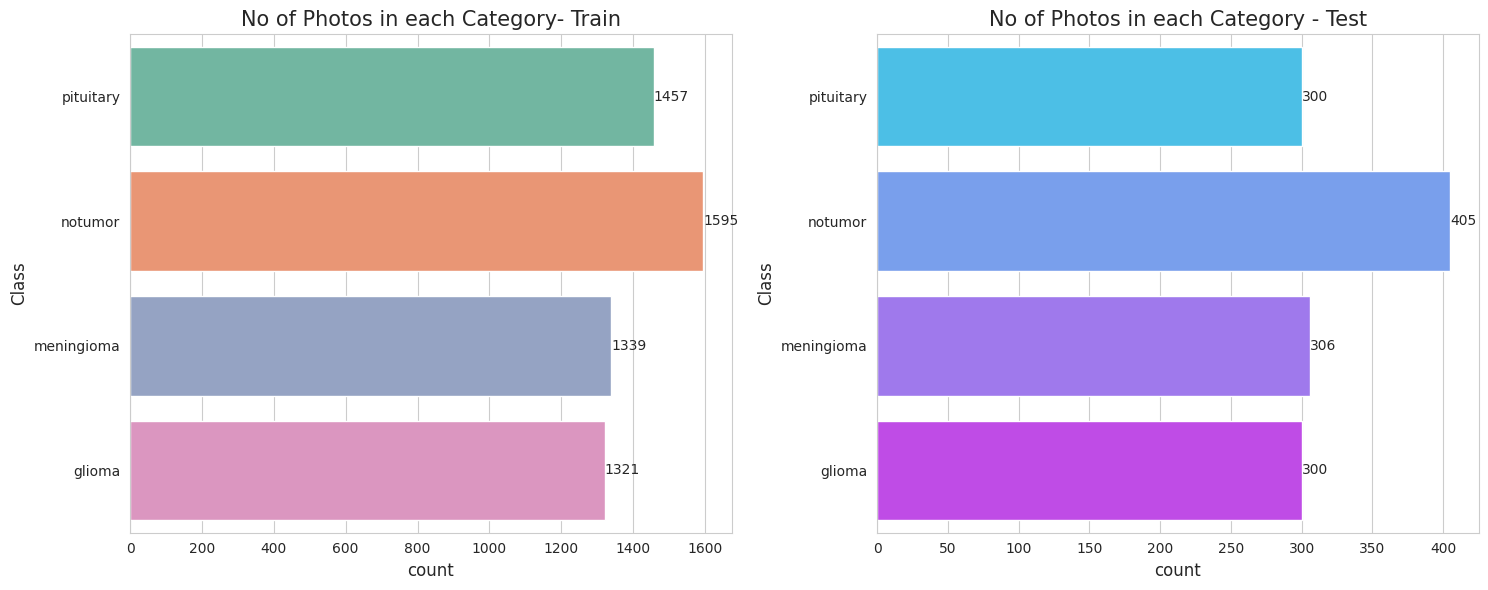

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(y='Class', data=tr_df, palette='Set2', ax=axs[0])
axs[0].set_title('No of Photos in each Category- Train', fontsize=15)
for c in axs[0].containers:
    axs[0].bar_label(c, fmt='%d', label_type="edge")

sns.countplot(y='Class', data=ts_df, palette='cool', ax=axs[1])
axs[1].set_title('No of Photos in each Category - Test', fontsize=15)
for c in axs[1].containers:
    axs[1].bar_label(c, fmt='%d', label_type="edge")

plt.tight_layout()
plt.show()


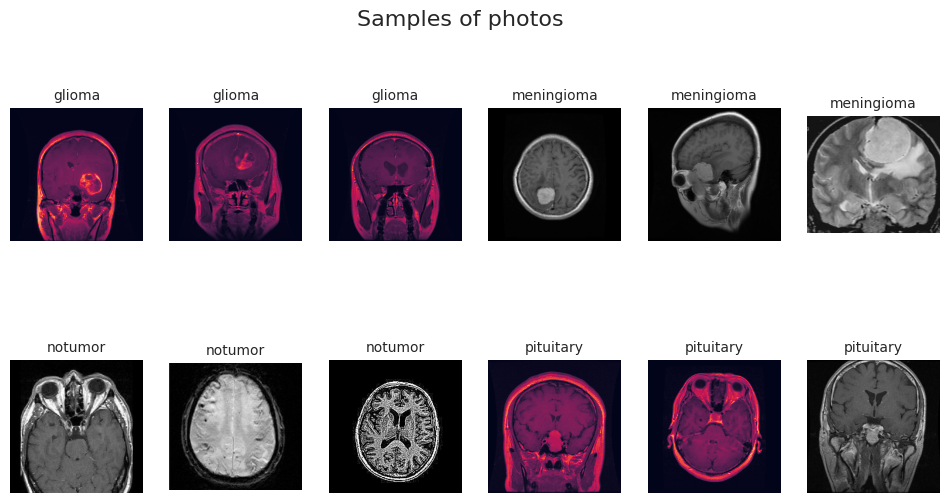

In [5]:
sample_df = tr_df.groupby('Class').sample(3, random_state=42)
plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_df.values):
    img = Image.open(row[0])
    plt.subplot(2, 6, i+1)
    plt.imshow(img)
    plt.title(row[1], fontsize=10)
    plt.axis('off')
plt.suptitle("Samples of photos", fontsize=16)
plt.show()

In [6]:
def pie_class_distribution(df, title='Class ratio'):
    counts = df['Class'].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

def sample_grid_per_class(df, n_per_class=4, figsize=(14,10)):
    classes = sorted(df['Class'].unique())
    plt.figure(figsize=figsize)
    idx = 1
    for c in classes:
        c_paths = df[df['Class'] == c]['Class Path'].tolist()
        selected = random.sample(c_paths, min(n_per_class, len(c_paths)))
        for p in selected:
            img = Image.open(p).convert('RGB')
            plt.subplot(len(classes), n_per_class, idx)
            plt.imshow(img.resize((200,200)))
            plt.axis('off')
            if idx % n_per_class == 1:
                plt.ylabel(c, fontsize=12)
            idx += 1
    plt.suptitle('Random samples per class', fontsize=16)
    plt.show()

def image_size_stats(df):
    widths = []
    heights = []
    for p in df['Class Path'].values:
        with Image.open(p) as im:
            w, h = im.size
        widths.append(w)
        heights.append(h)
    stats = pd.DataFrame({'width': widths, 'height': heights})
    print(stats.describe().T)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(stats['width'], bins=30)
    plt.title('Width distribution')
    plt.subplot(1,2,2)
    sns.histplot(stats['height'], bins=30)
    plt.title('Height distribution')
    plt.show()

def average_image_by_class(df, target_size=(299,299)):
    classes = sorted(df['Class'].unique())
    plt.figure(figsize=(12,3*len(classes)))
    for i,c in enumerate(classes, start=1):
        paths = df[df['Class']==c]['Class Path'].tolist()
        acc = np.zeros((target_size[1], target_size[0], 3), dtype=np.float32)
        for p in paths:
            im = Image.open(p).convert('RGB').resize(target_size)
            acc += np.asarray(im, dtype=np.float32) / 255.0
        avg = acc / len(paths)
        plt.subplot(len(classes), 1, i)
        plt.imshow(np.clip(avg,0,1))
        plt.title(f'Average image for class: {c}  (n={len(paths)})')
        plt.axis('off')
    plt.show()


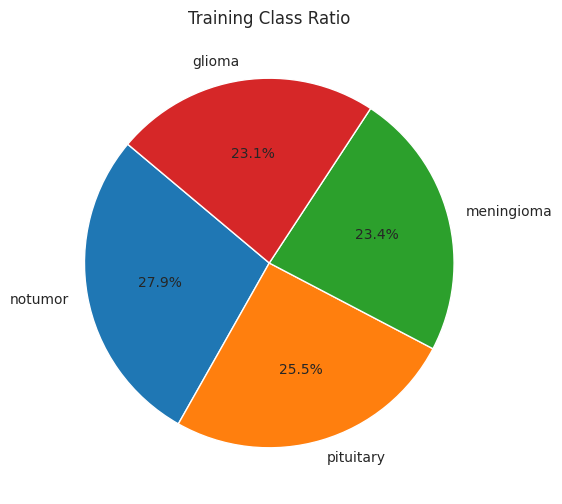

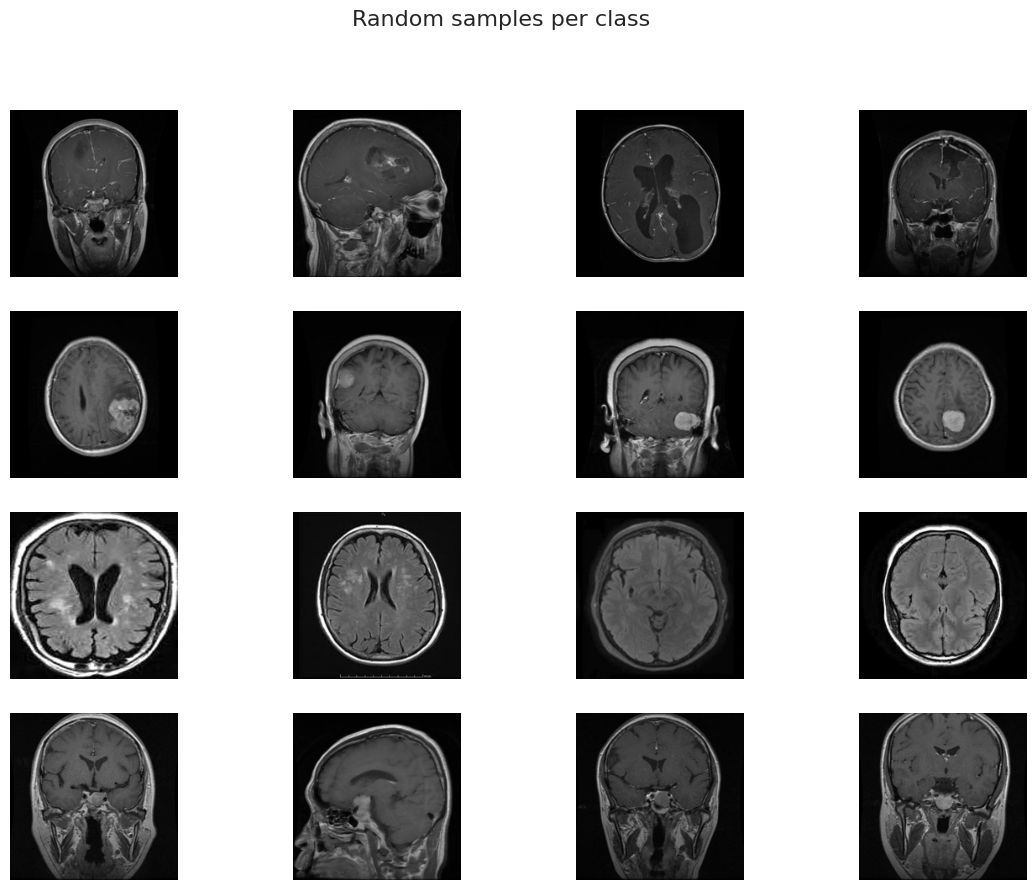

         count        mean         std    min    25%    50%    75%     max
width   5712.0  451.563200  131.004291  150.0  441.0  512.0  512.0  1920.0
height  5712.0  453.883754  124.779164  168.0  442.0  512.0  512.0  1446.0


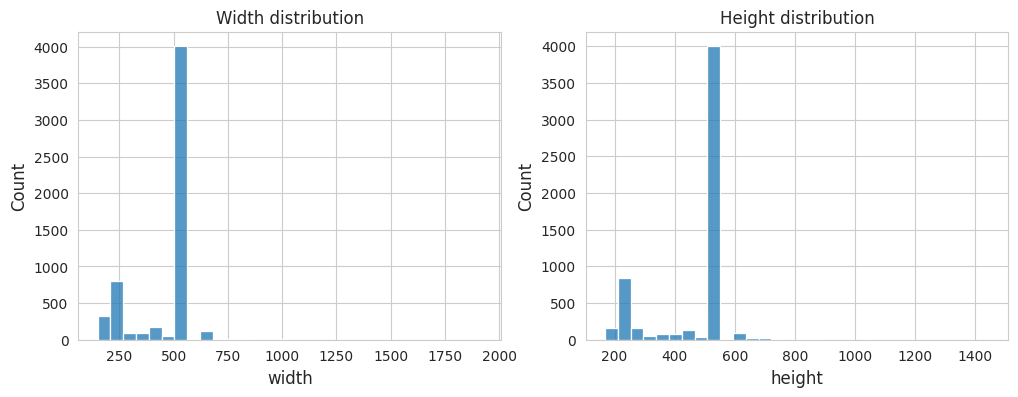

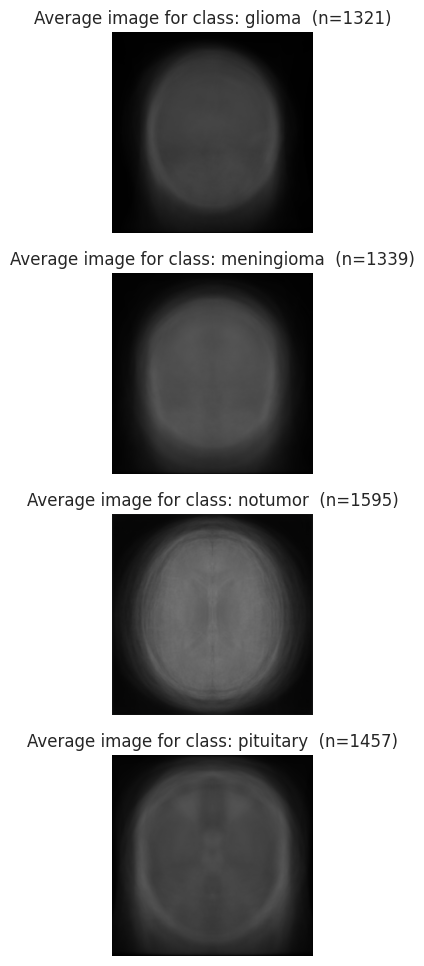

In [7]:

import random

pie_class_distribution(tr_df, 'Training Class Ratio')
sample_grid_per_class(tr_df, n_per_class=4)
image_size_stats(tr_df)
average_image_by_class(tr_df, target_size=(299,299))


## 2.2 Split data into train, test, valid

In [8]:
valid_df, ts_df = train_test_split(
    ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class']
)

## 2.3 Data preprocessing

In [9]:
batch_size = 32
img_size = (299, 299)

train_gen_aug = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
test_gen = ImageDataGenerator(rescale=1/255)

tr_gen = train_gen_aug.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class',
                                           batch_size=batch_size, target_size=img_size)

valid_gen = train_gen_aug.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class',
                                              batch_size=batch_size, target_size=img_size)

ts_gen = test_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class',
                                      batch_size=16, target_size=img_size, shuffle=False)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# 3. Building Deep Learning Model

In [10]:
img_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

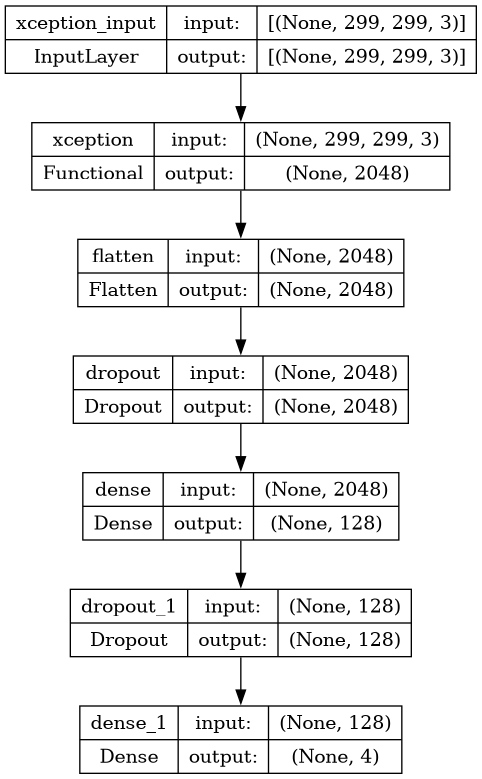

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [12]:
history = model.fit(tr_gen, epochs=10, validation_data=valid_gen, shuffle=False)


Epoch 1/10
179/179 [==============================] - 128s 533ms/step - loss: 0.3301 - accuracy: 0.8892 - precision: 0.9223 - recall: 0.8587 - val_loss: 0.1790 - val_accuracy: 0.9298 - val_precision: 0.9311 - val_recall: 0.9282
Epoch 2/10
179/179 [==============================] - 89s 495ms/step - loss: 0.0565 - accuracy: 0.9814 - precision: 0.9819 - recall: 0.9802 - val_loss: 0.1809 - val_accuracy: 0.9115 - val_precision: 0.9153 - val_recall: 0.9069
Epoch 3/10
179/179 [==============================] - 89s 495ms/step - loss: 0.0220 - accuracy: 0.9928 - precision: 0.9932 - recall: 0.9923 - val_loss: 0.2654 - val_accuracy: 0.9099 - val_precision: 0.9154 - val_recall: 0.9084
Epoch 4/10
179/179 [==============================] - 89s 495ms/step - loss: 0.0244 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9921 - val_loss: 0.0237 - val_accuracy: 0.9893 - val_precision: 0.9893 - val_recall: 0.9893
Epoch 5/10
179/179 [==============================] - 89s 495ms/step - loss: 0.0165 - accur

In [13]:
metrics = ['accuracy', 'loss', 'precision', 'recall']
colors = ['#2ca02c', '#d62728', '#1f77b4', '#ff7f0e']

## 4.1 Visualize model performance

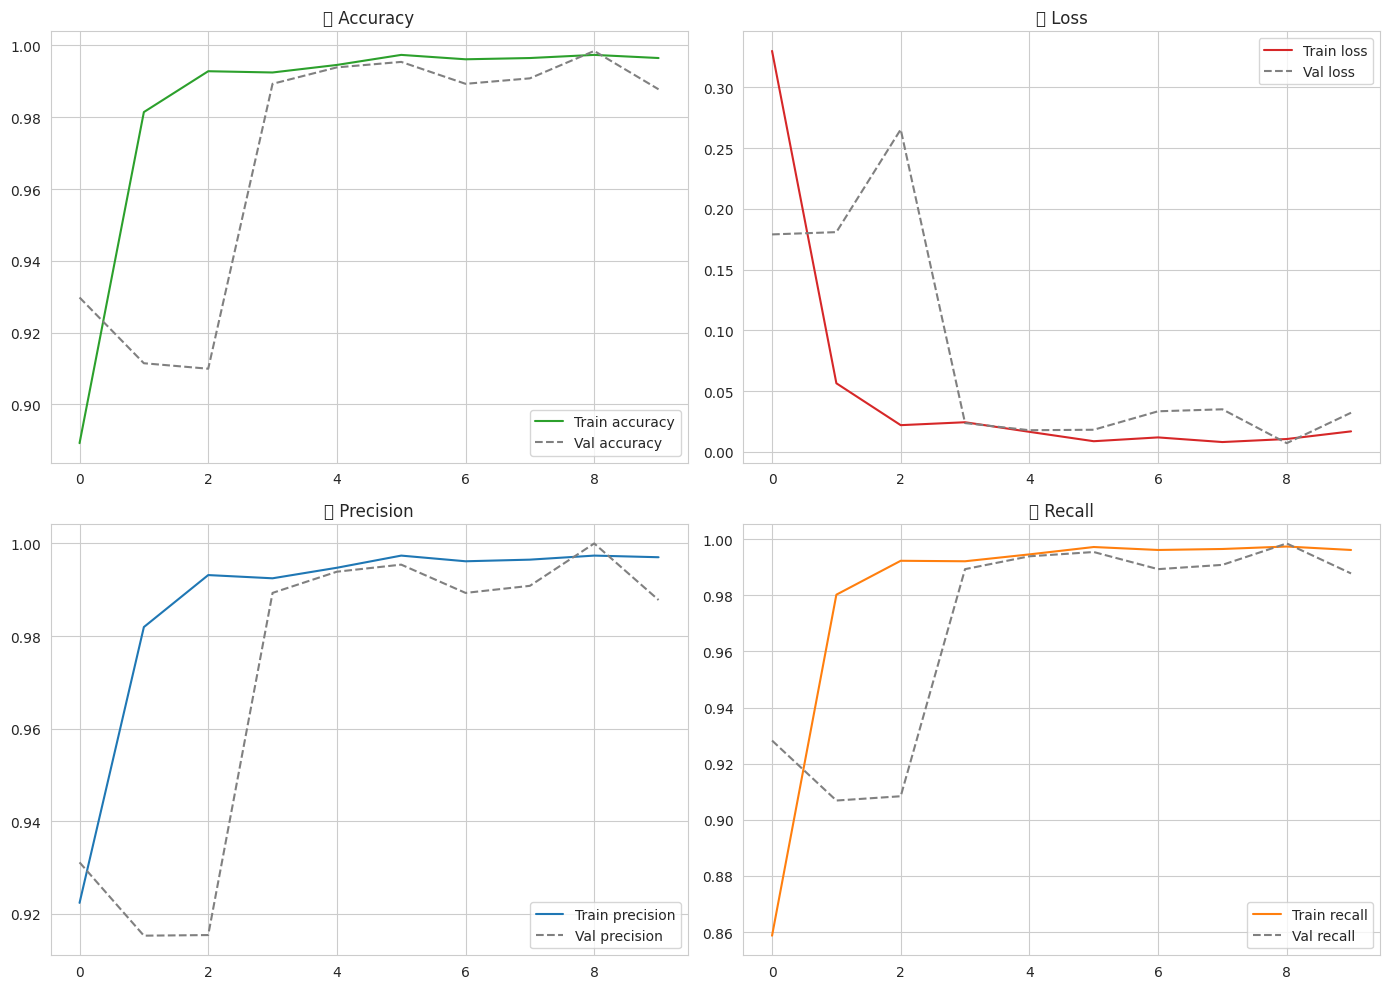

In [14]:
plt.figure(figsize=(14, 10))
for i, m in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    plt.plot(history.history[m], label=f'Train {m}', color=colors[i-1])
    plt.plot(history.history[f'val_{m}'], label=f'Val {m}', linestyle='--', color='gray')
    plt.title(f'📈 {m.capitalize()}')
    plt.legend()
plt.tight_layout()
plt.show()


# 5. Testing and Evaluation

## 5.1 Evaluate

In [15]:
train_score = model.evaluate(tr_gen, verbose=0)
valid_score = model.evaluate(valid_gen, verbose=0)
test_score = model.evaluate(ts_gen, verbose=0)

print("\n📌 **Model Performance Summary**")
print(f"✅ Train Accuracy: {train_score[1]*100:.2f}%")
print(f"📊 Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"🧪 Test Accuracy: {test_score[1]*100:.2f}%")


📌 **Model Performance Summary**
✅ Train Accuracy: 99.81%
📊 Validation Accuracy: 98.93%
🧪 Test Accuracy: 98.48%


In [16]:
y_pred = np.argmax(model.predict(ts_gen), axis=1)
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(tr_gen.class_indices.keys())


41/41 [==============================] - 4s 71ms/step


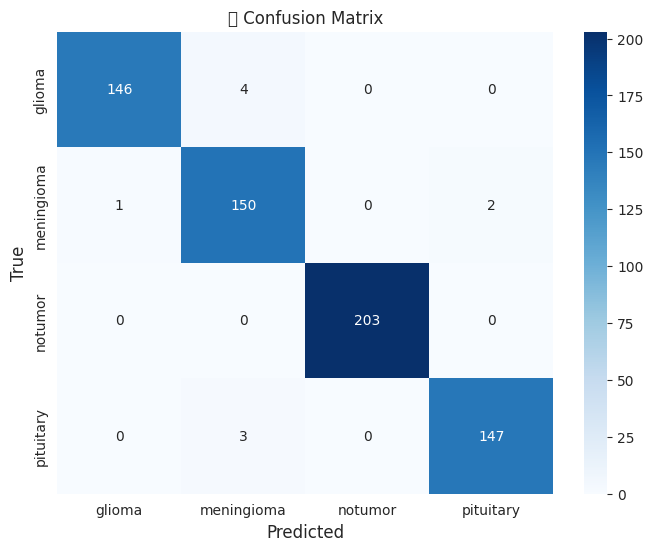

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("🔍 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [18]:
print("\n📄 Classification Report:")
print(classification_report(ts_gen.classes, y_pred, target_names=labels))



📄 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       150
  meningioma       0.96      0.98      0.97       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      0.98      0.98       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656

